In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from court_detector import CourtDetector
from skimage.morphology import skeletonize

In [2]:
def crop_image(img, x_ct, y_ct, crop_size=40):
    refined_x_ct, refined_y_ct = int(x_ct), int(y_ct)
    
    img_height, img_width = img.shape[:2]
    x_min = max(refined_x_ct - crop_size, 0)
    x_max = min(refined_x_ct + crop_size, img_width)
    y_min = max(refined_y_ct - crop_size, 0)
    y_max = min(refined_y_ct + crop_size, img_height)

    img_crop = img[y_min:y_max, x_min:x_max]
    return img_crop

In [3]:
def niblack_thresholding(image, window_size, k):
    mean = cv2.blur(image, (window_size, window_size))
    mean_of_squares = cv2.blur(image**2, (window_size, window_size))
    std_deviation = np.sqrt(mean_of_squares - mean**2)
    threshold = mean + k * std_deviation

    binary_image = (image > threshold).astype(np.uint8) * 255

    return binary_image

In [4]:
def draw_full_lines(image, lines=None):
    if lines is not None:
        for linea in lines:
            x1, y1, x2, y2 = linea
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [5]:
def detect_lines(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape[:2]
    binary = niblack_thresholding(gray, width, height)

    # Edge detection
    canny_edges = cv2.Canny(binary, 0, 5, apertureSize=3)

    # Morphological operations
    dilation = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)
    erosion = cv2.erode(dilation, np.ones((4,4), np.uint8), iterations=1)
    skeletonized = (skeletonize(erosion/255)*255).astype(np.uint8)

    # Hough Transform - Line Detection
    linesP = cv2.HoughLinesP(skeletonized, 1, np.pi / 180, 3, minLineLength=1, maxLineGap=5)

    # Handle the case where no lines are detected
    if linesP is not None:
        linesP = np.squeeze(linesP) 
        if len(linesP.shape) > 0:
            if len(linesP) == 4 and not isinstance(linesP[0], np.ndarray): linesP = [linesP]
        else:
            linesP = []
    else:
        linesP = []

    return linesP

In [6]:
cd = CourtDetector('../models/keypoints_model.pth')
frame = cv2.imread('../data/raw/court/test_images/test_image3.jpg')

/Users/guillermosantosbarrios/Developer/Universidad/2024/computer vision/ProyectoFinal_VC/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/guillermosantosbarrios/Developer/Universidad/2024/computer vision/ProyectoFinal_VC/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
keypoints = cd.detect(frame)
keypoints = keypoints.reshape(-1, 2)
keypoints

array([[ 372.87625,  213.59044],
       [ 905.7126 ,  213.53795],
       [ 140.64578,  583.04297],
       [1132.1559 ,  581.9739 ],
       [ 439.96573,  213.55238],
       [ 264.7363 ,  582.91437],
       [ 839.13367,  213.50055],
       [1007.4224 ,  581.88306],
       [ 416.0737 ,  265.04855],
       [ 862.0961 ,  264.86316],
       [ 327.75696,  449.33356],
       [ 944.9375 ,  449.02618],
       [ 638.4708 ,  264.9228 ],
       [ 636.04944,  449.14133]], dtype=float32)

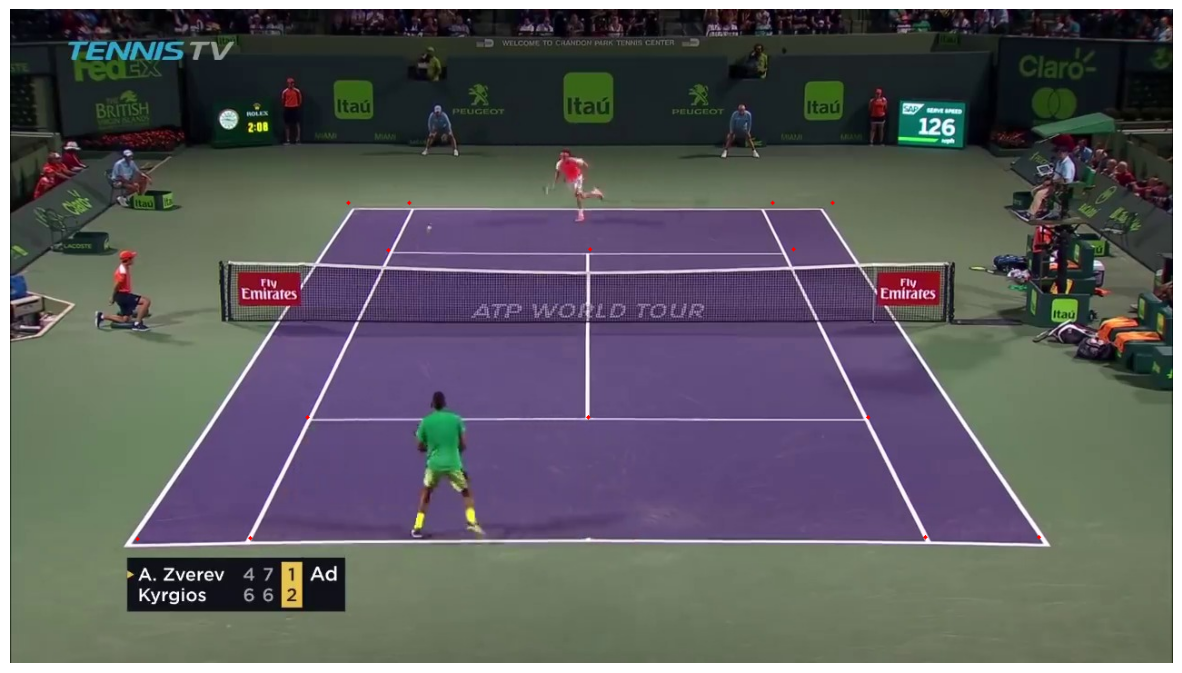

In [8]:
frame_kps = frame.copy()
for kp in keypoints:
    x, y = kp
    cv2.circle(frame_kps, (int(x), int(y)), 2, (0, 0, 255), -1)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(frame_kps, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


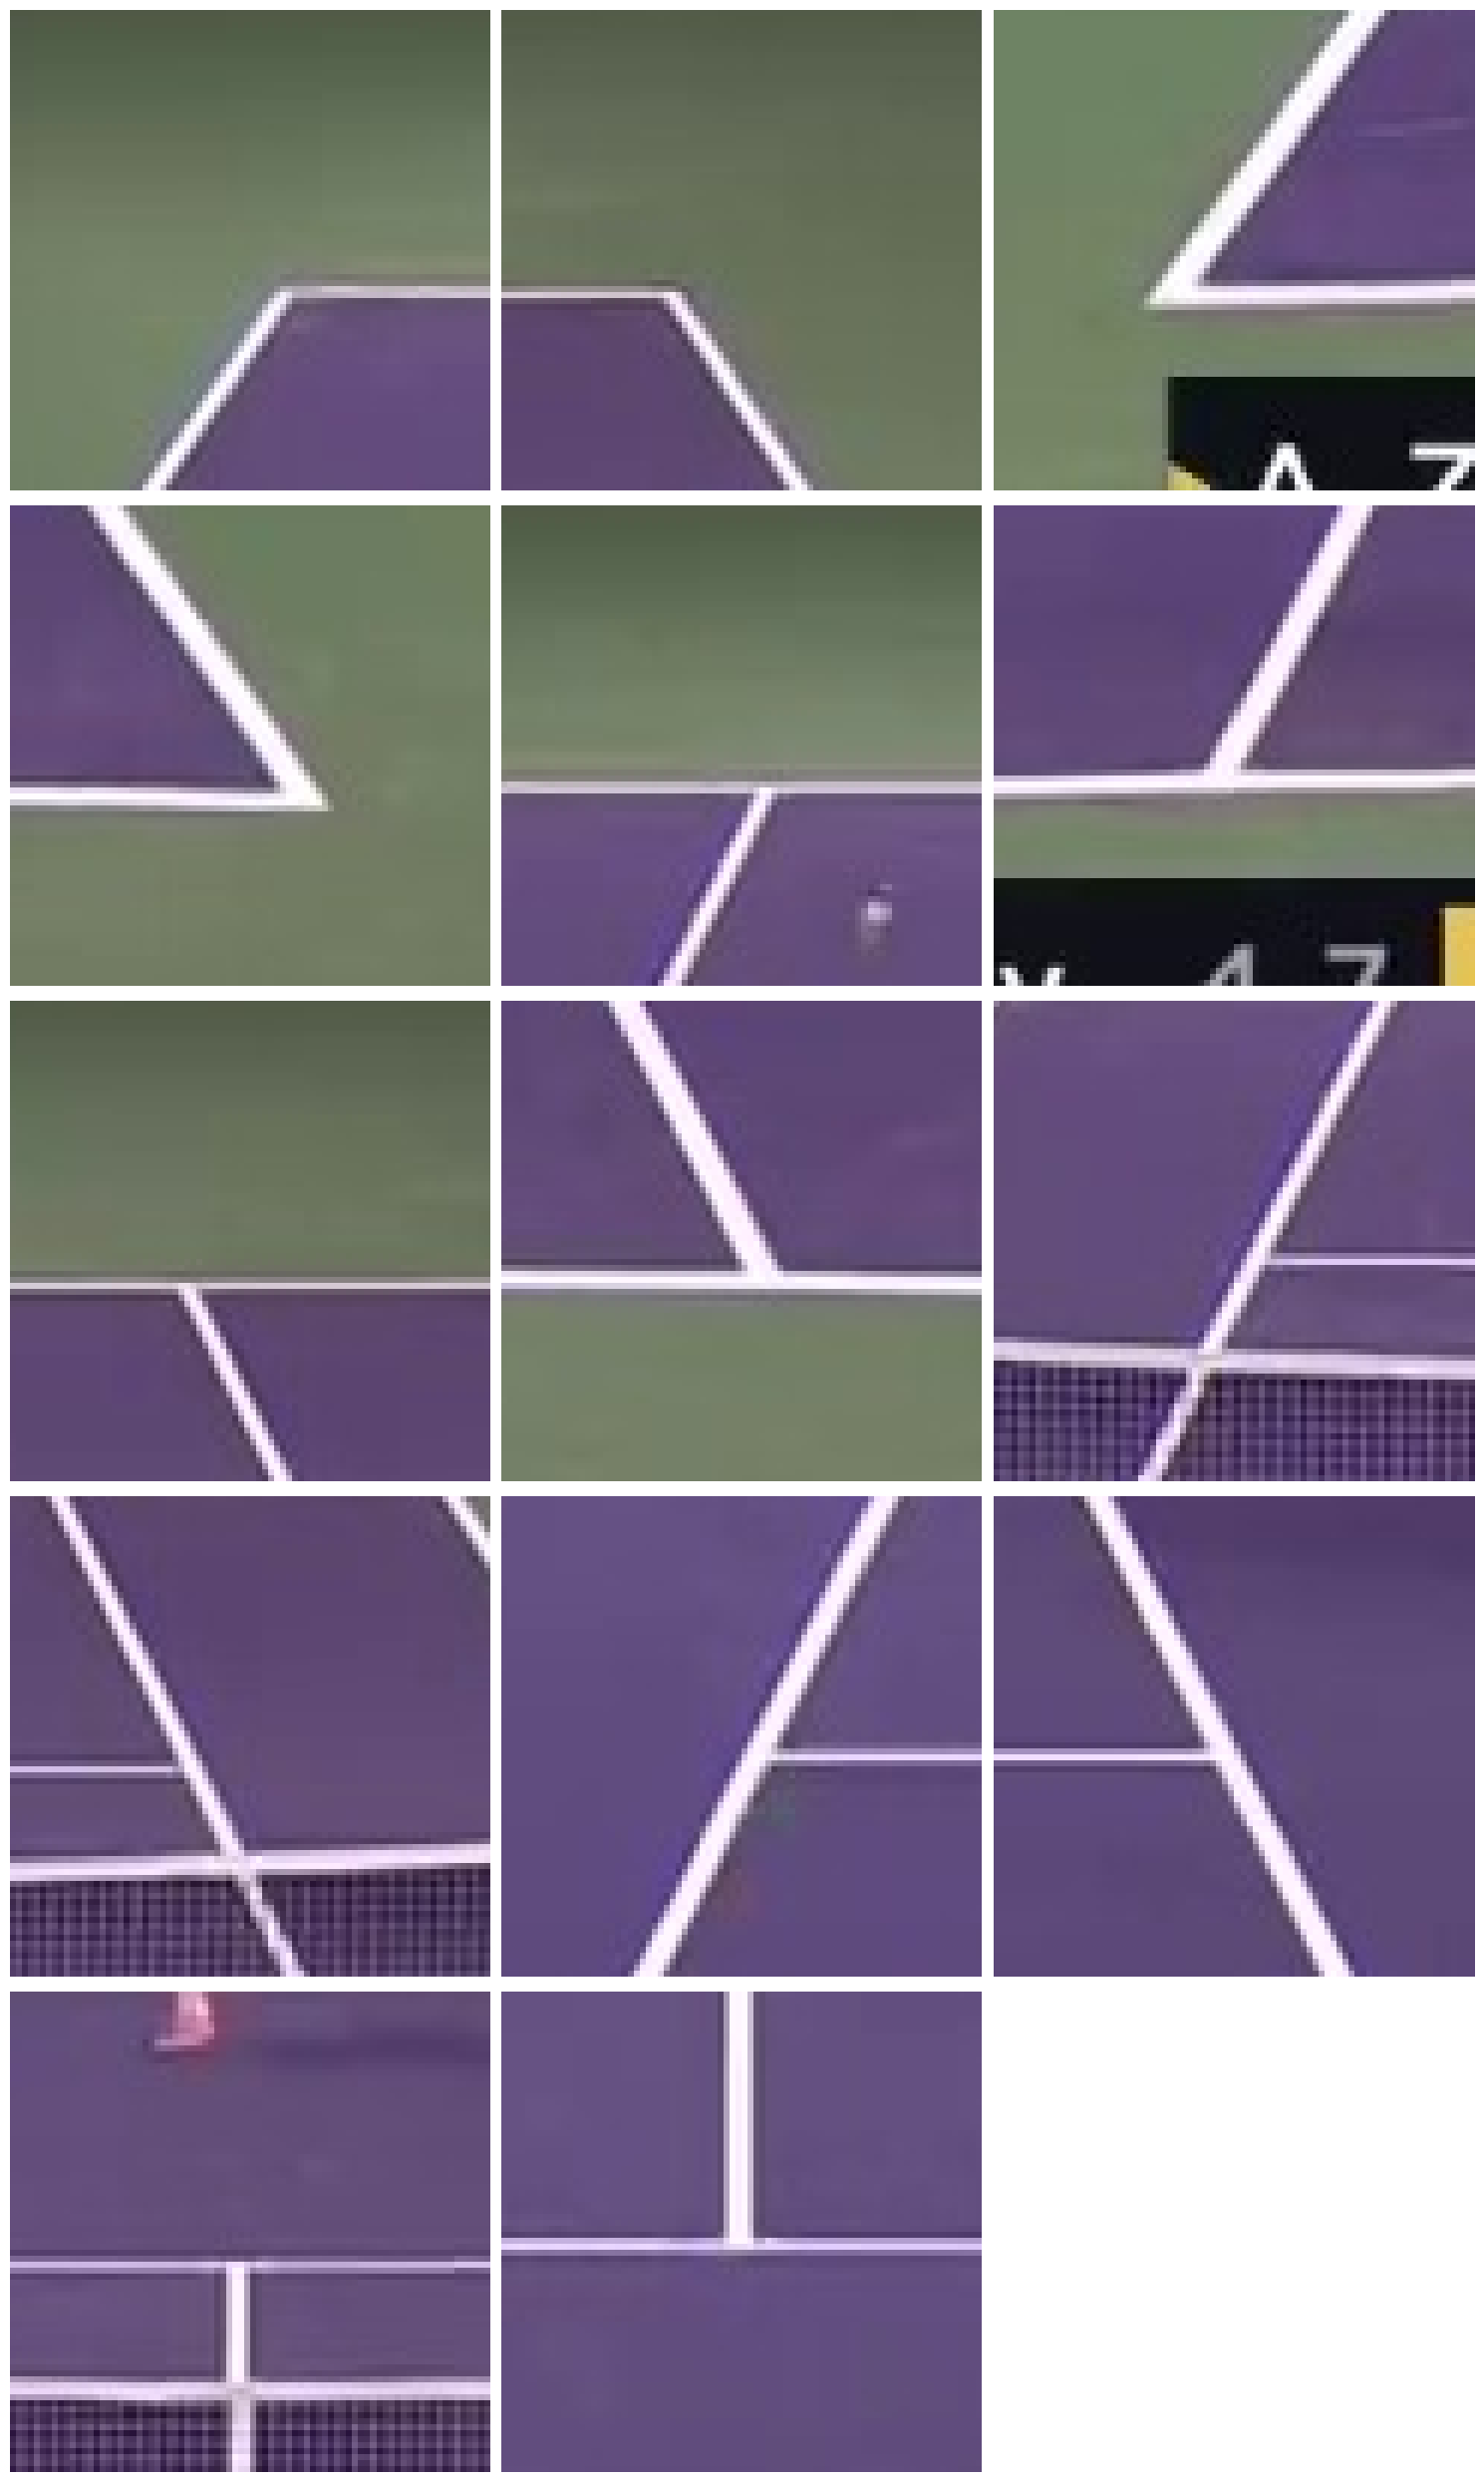

In [9]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

# Cropeed images around keypoints
cropped_images = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, kp in enumerate(keypoints):
    x, y = kp
    cropped = crop_image(frame, x, y)
    cropped_images.append(cropped)
    
    row, col = divmod(i, n_cols)
    axs[row, col].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

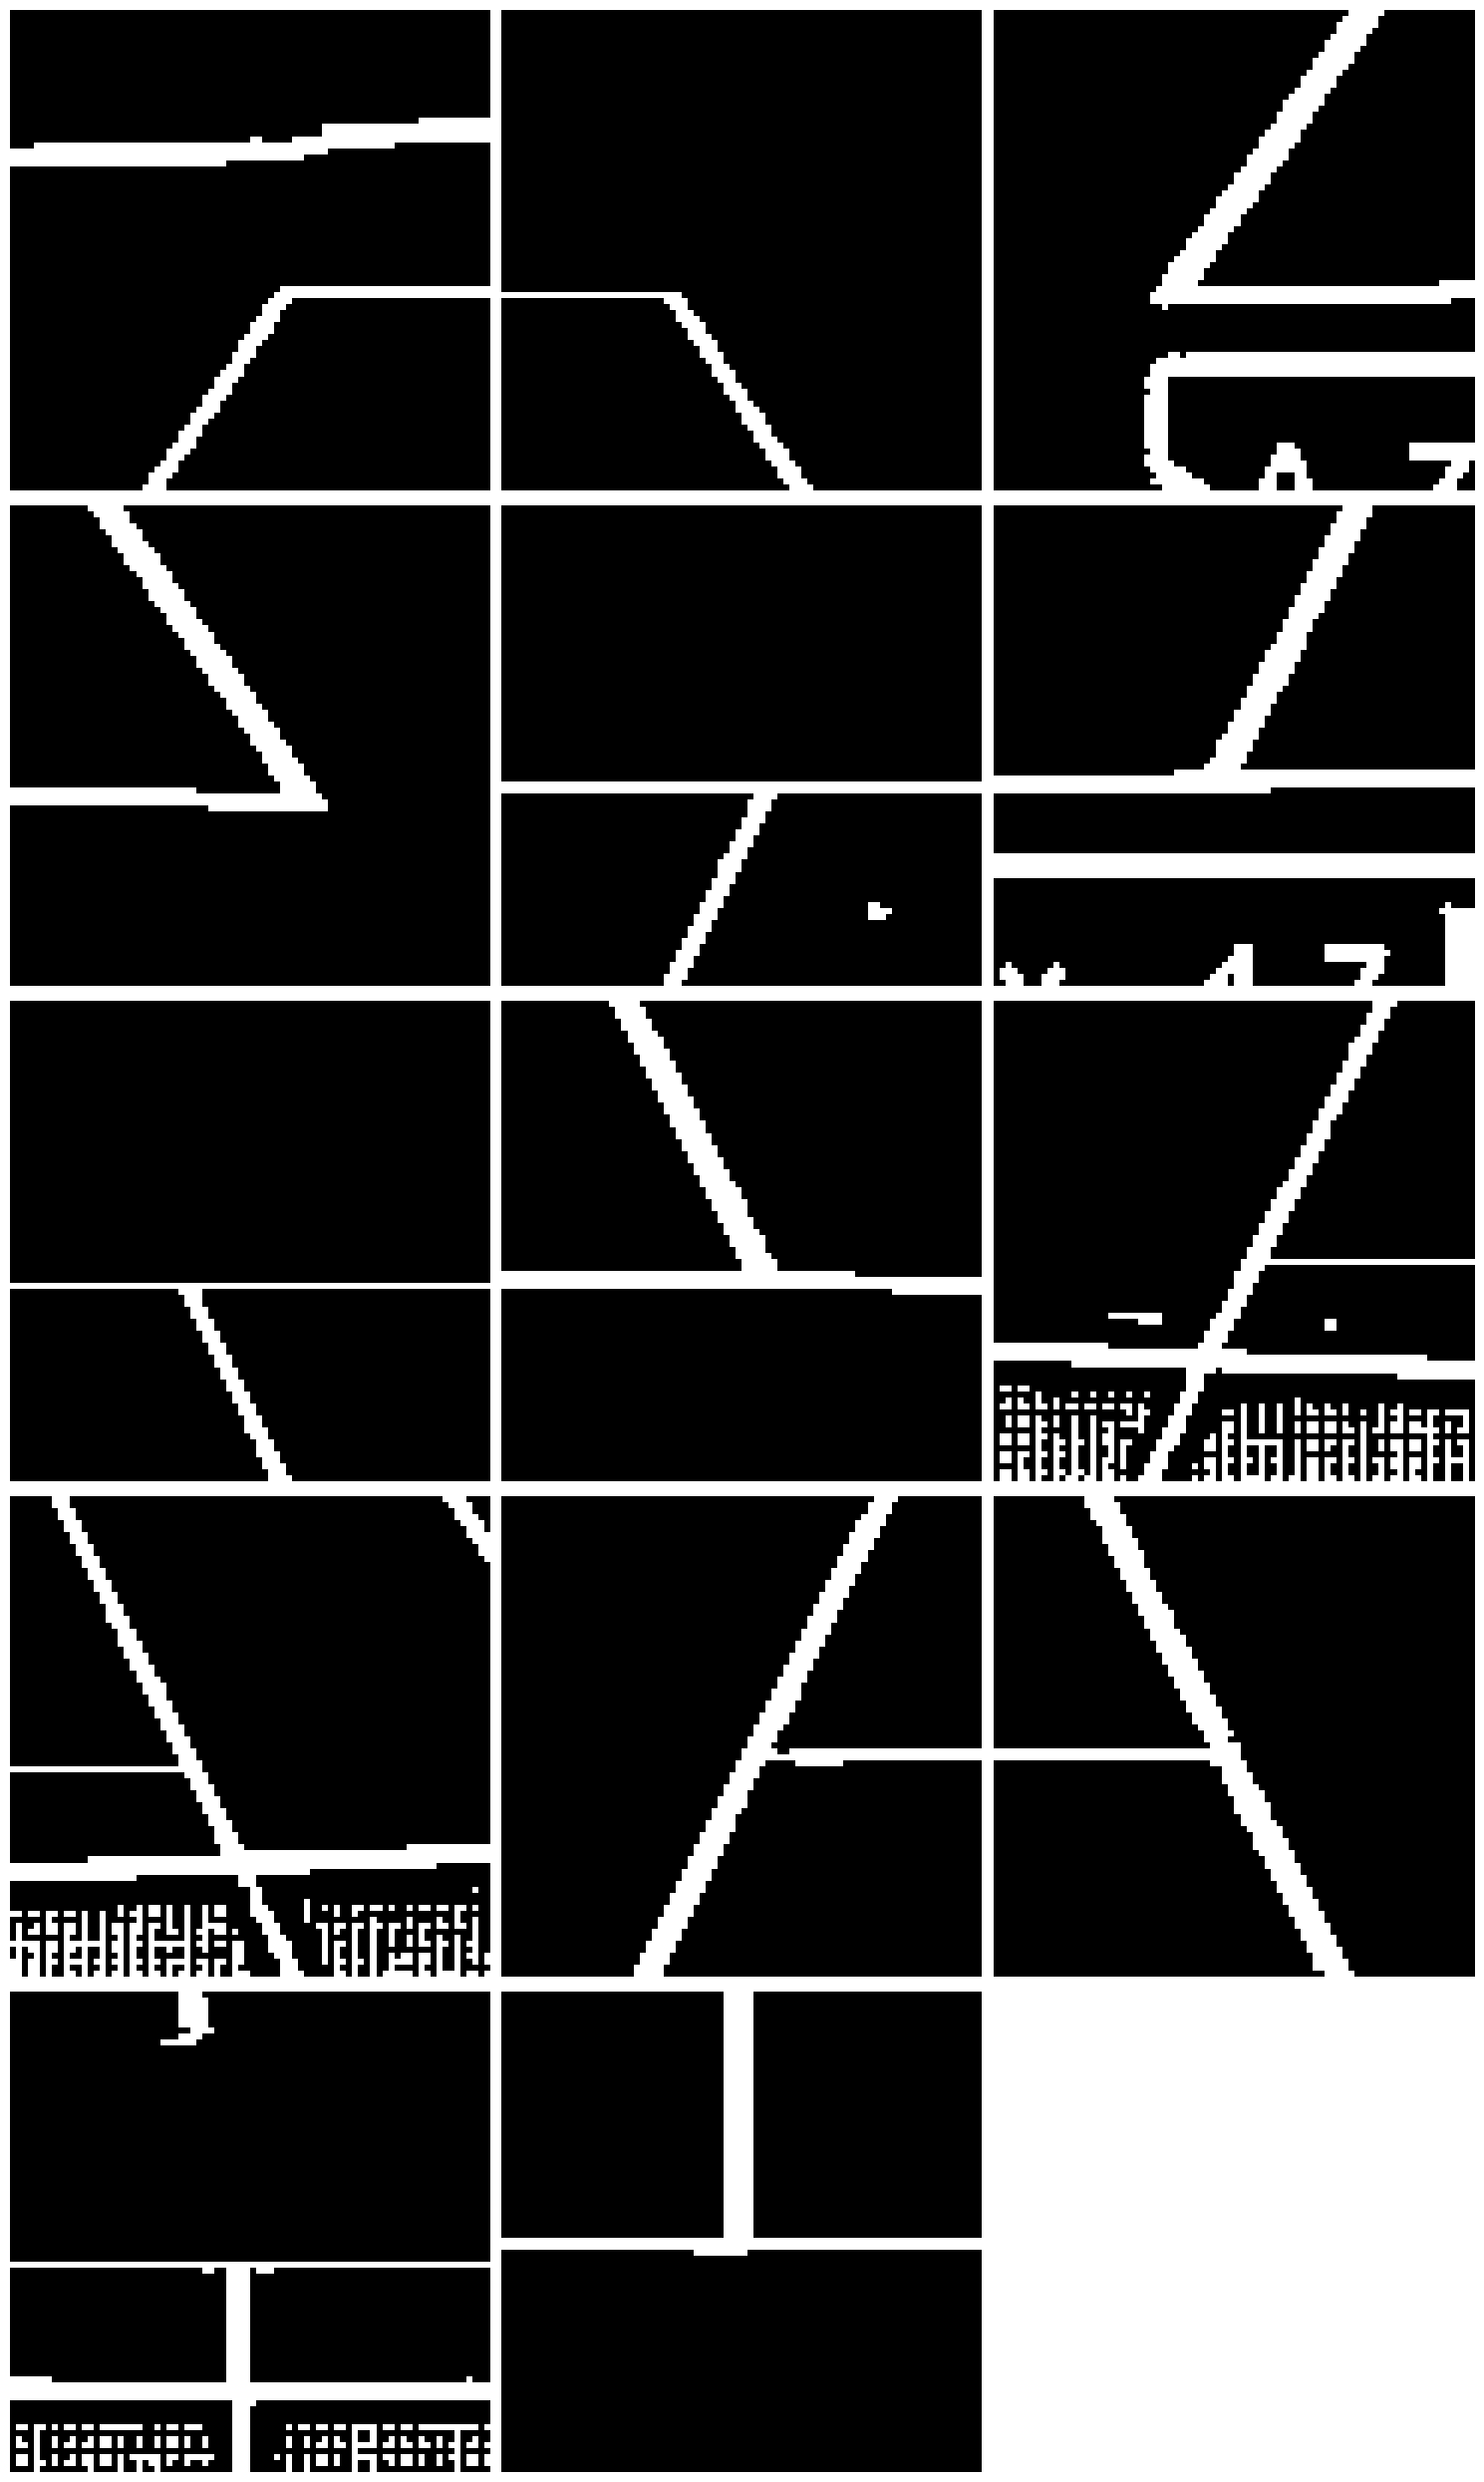

In [10]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

binarized_images = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, cri in enumerate(cropped_images):

    # image quantization
    pixels = cri.reshape((-1, 3))
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    k = 3
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    quantized_pixels = centers[labels.flatten()]
    quantized_image = quantized_pixels.reshape(cri.shape)

    gray_image = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2GRAY)
    binary_image = niblack_thresholding(gray_image, 10, 0.5)
    binarized_images.append(binary_image)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(binary_image, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

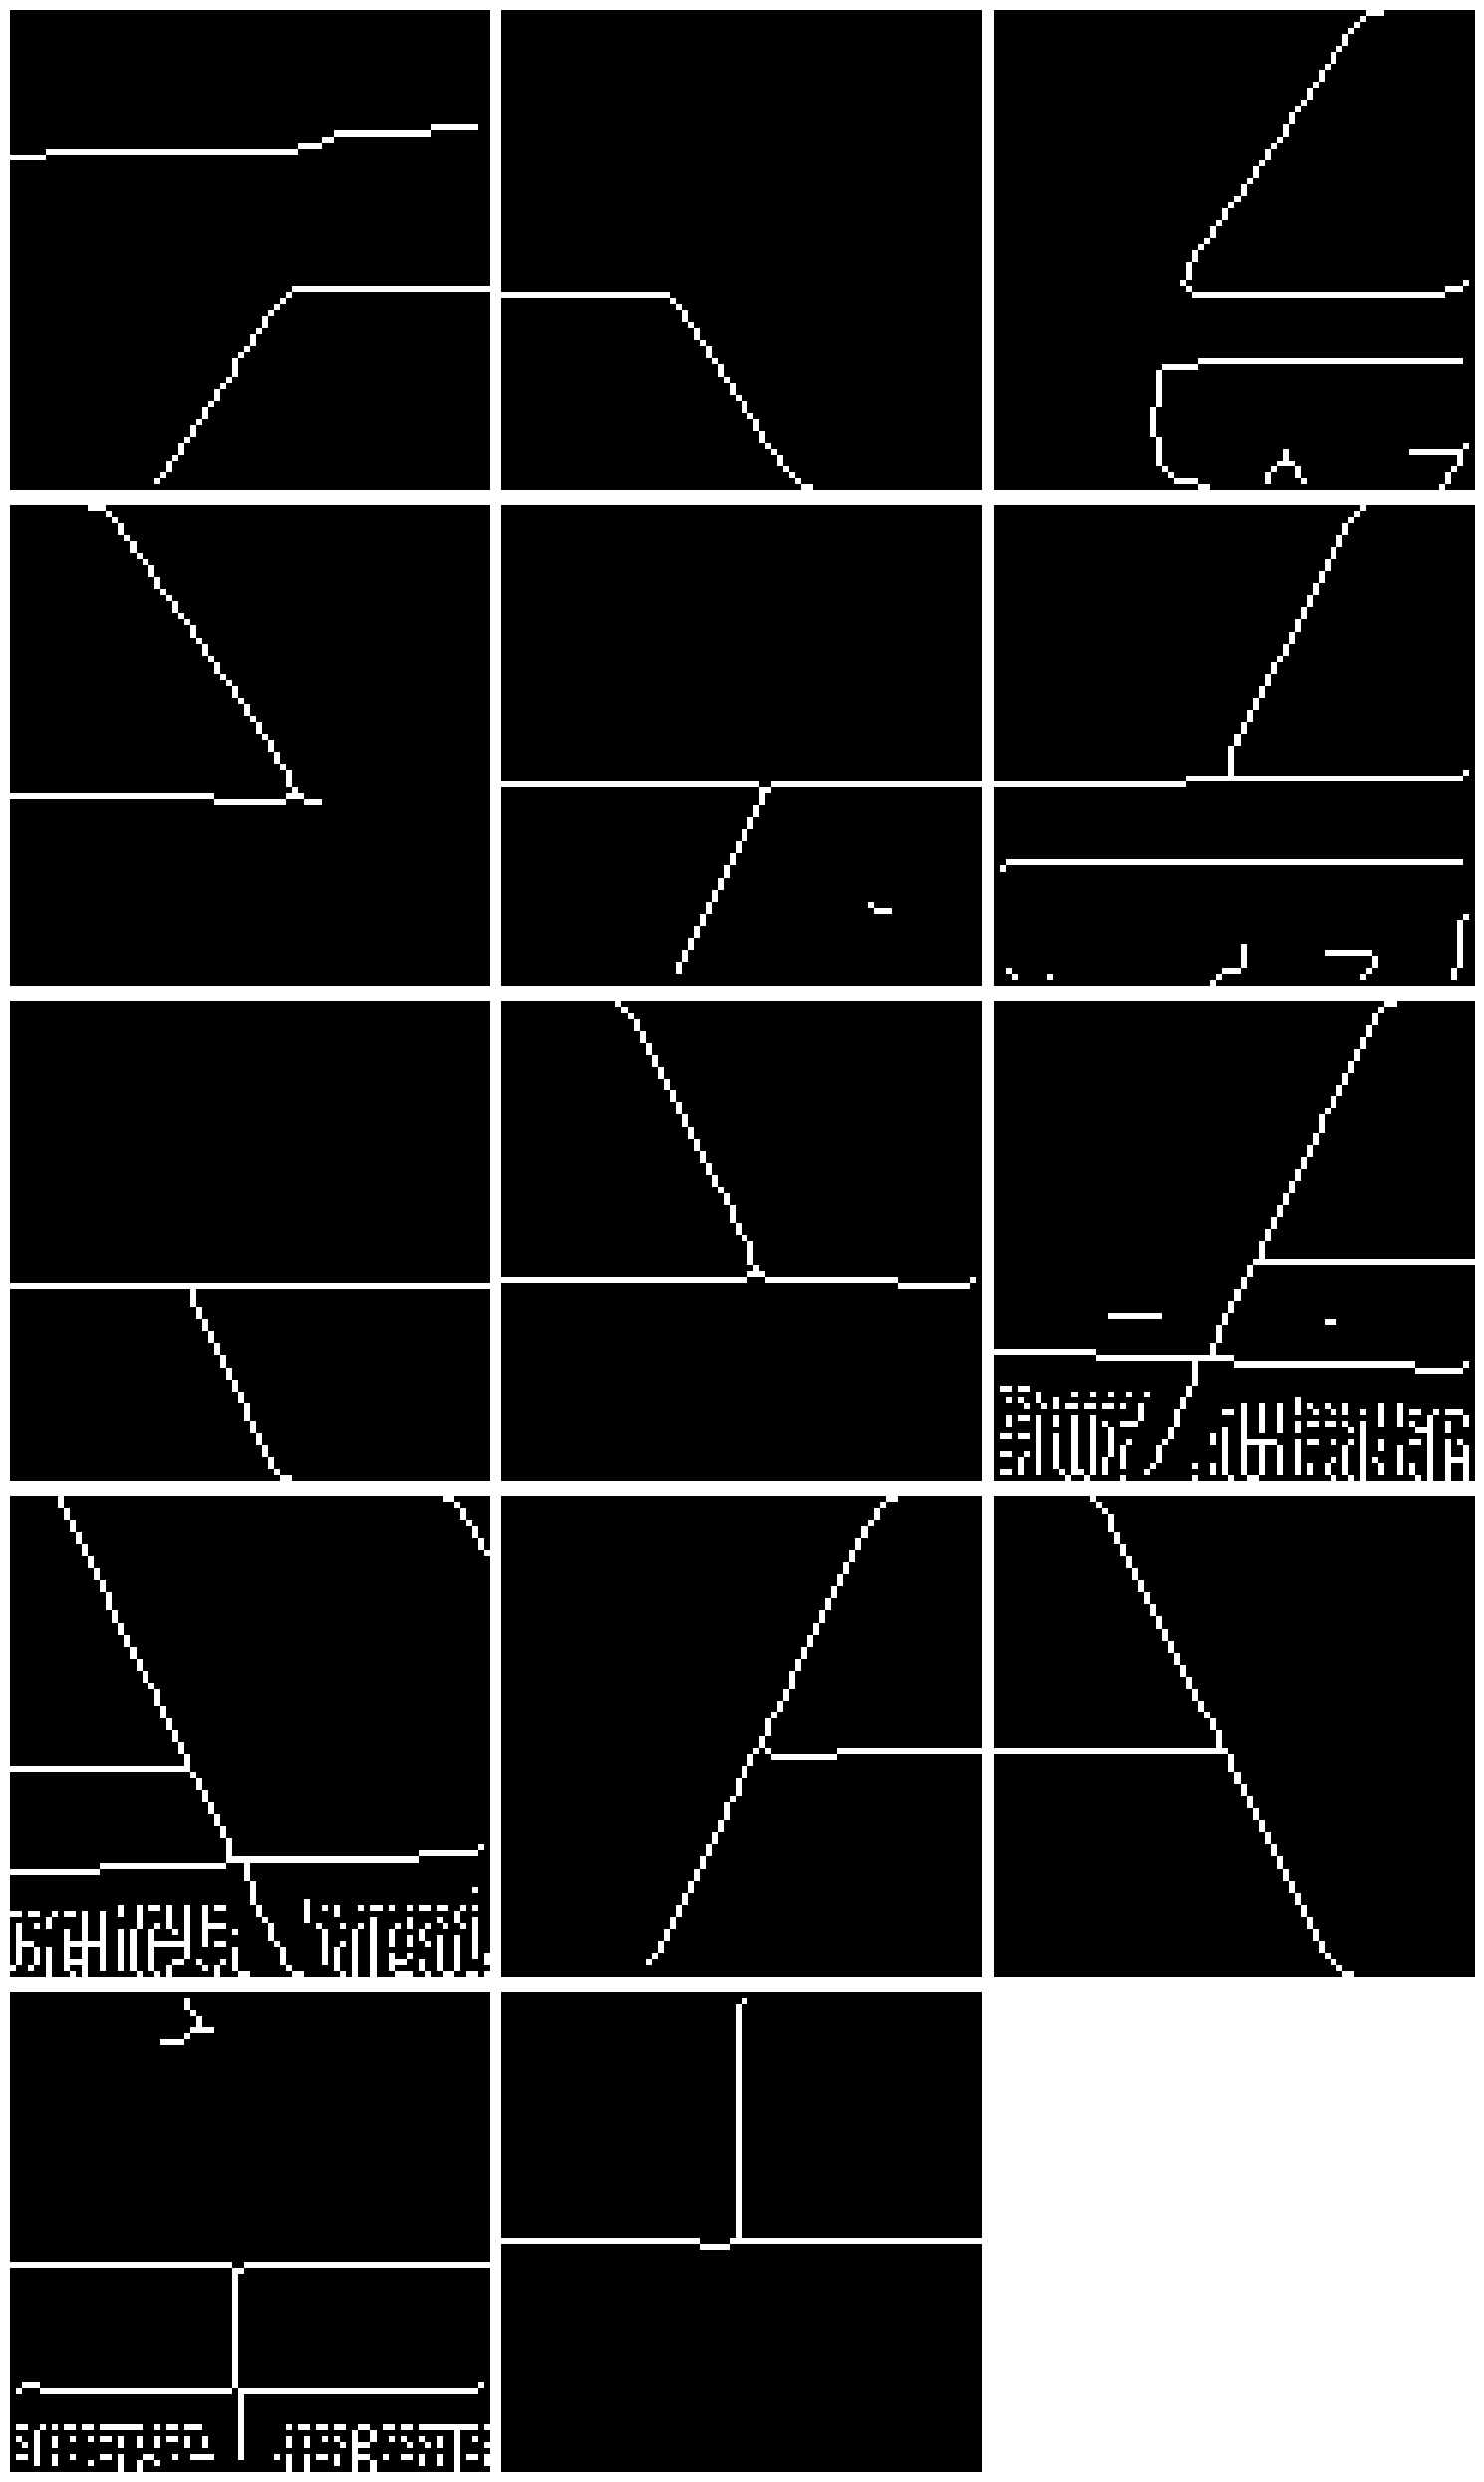

In [11]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

skeletons = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, erosion_el in enumerate(binarized_images):

    skeletonized = (skeletonize(erosion_el/255)*255).astype(np.uint8)
    skeletons.append(skeletonized)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(skeletonized, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

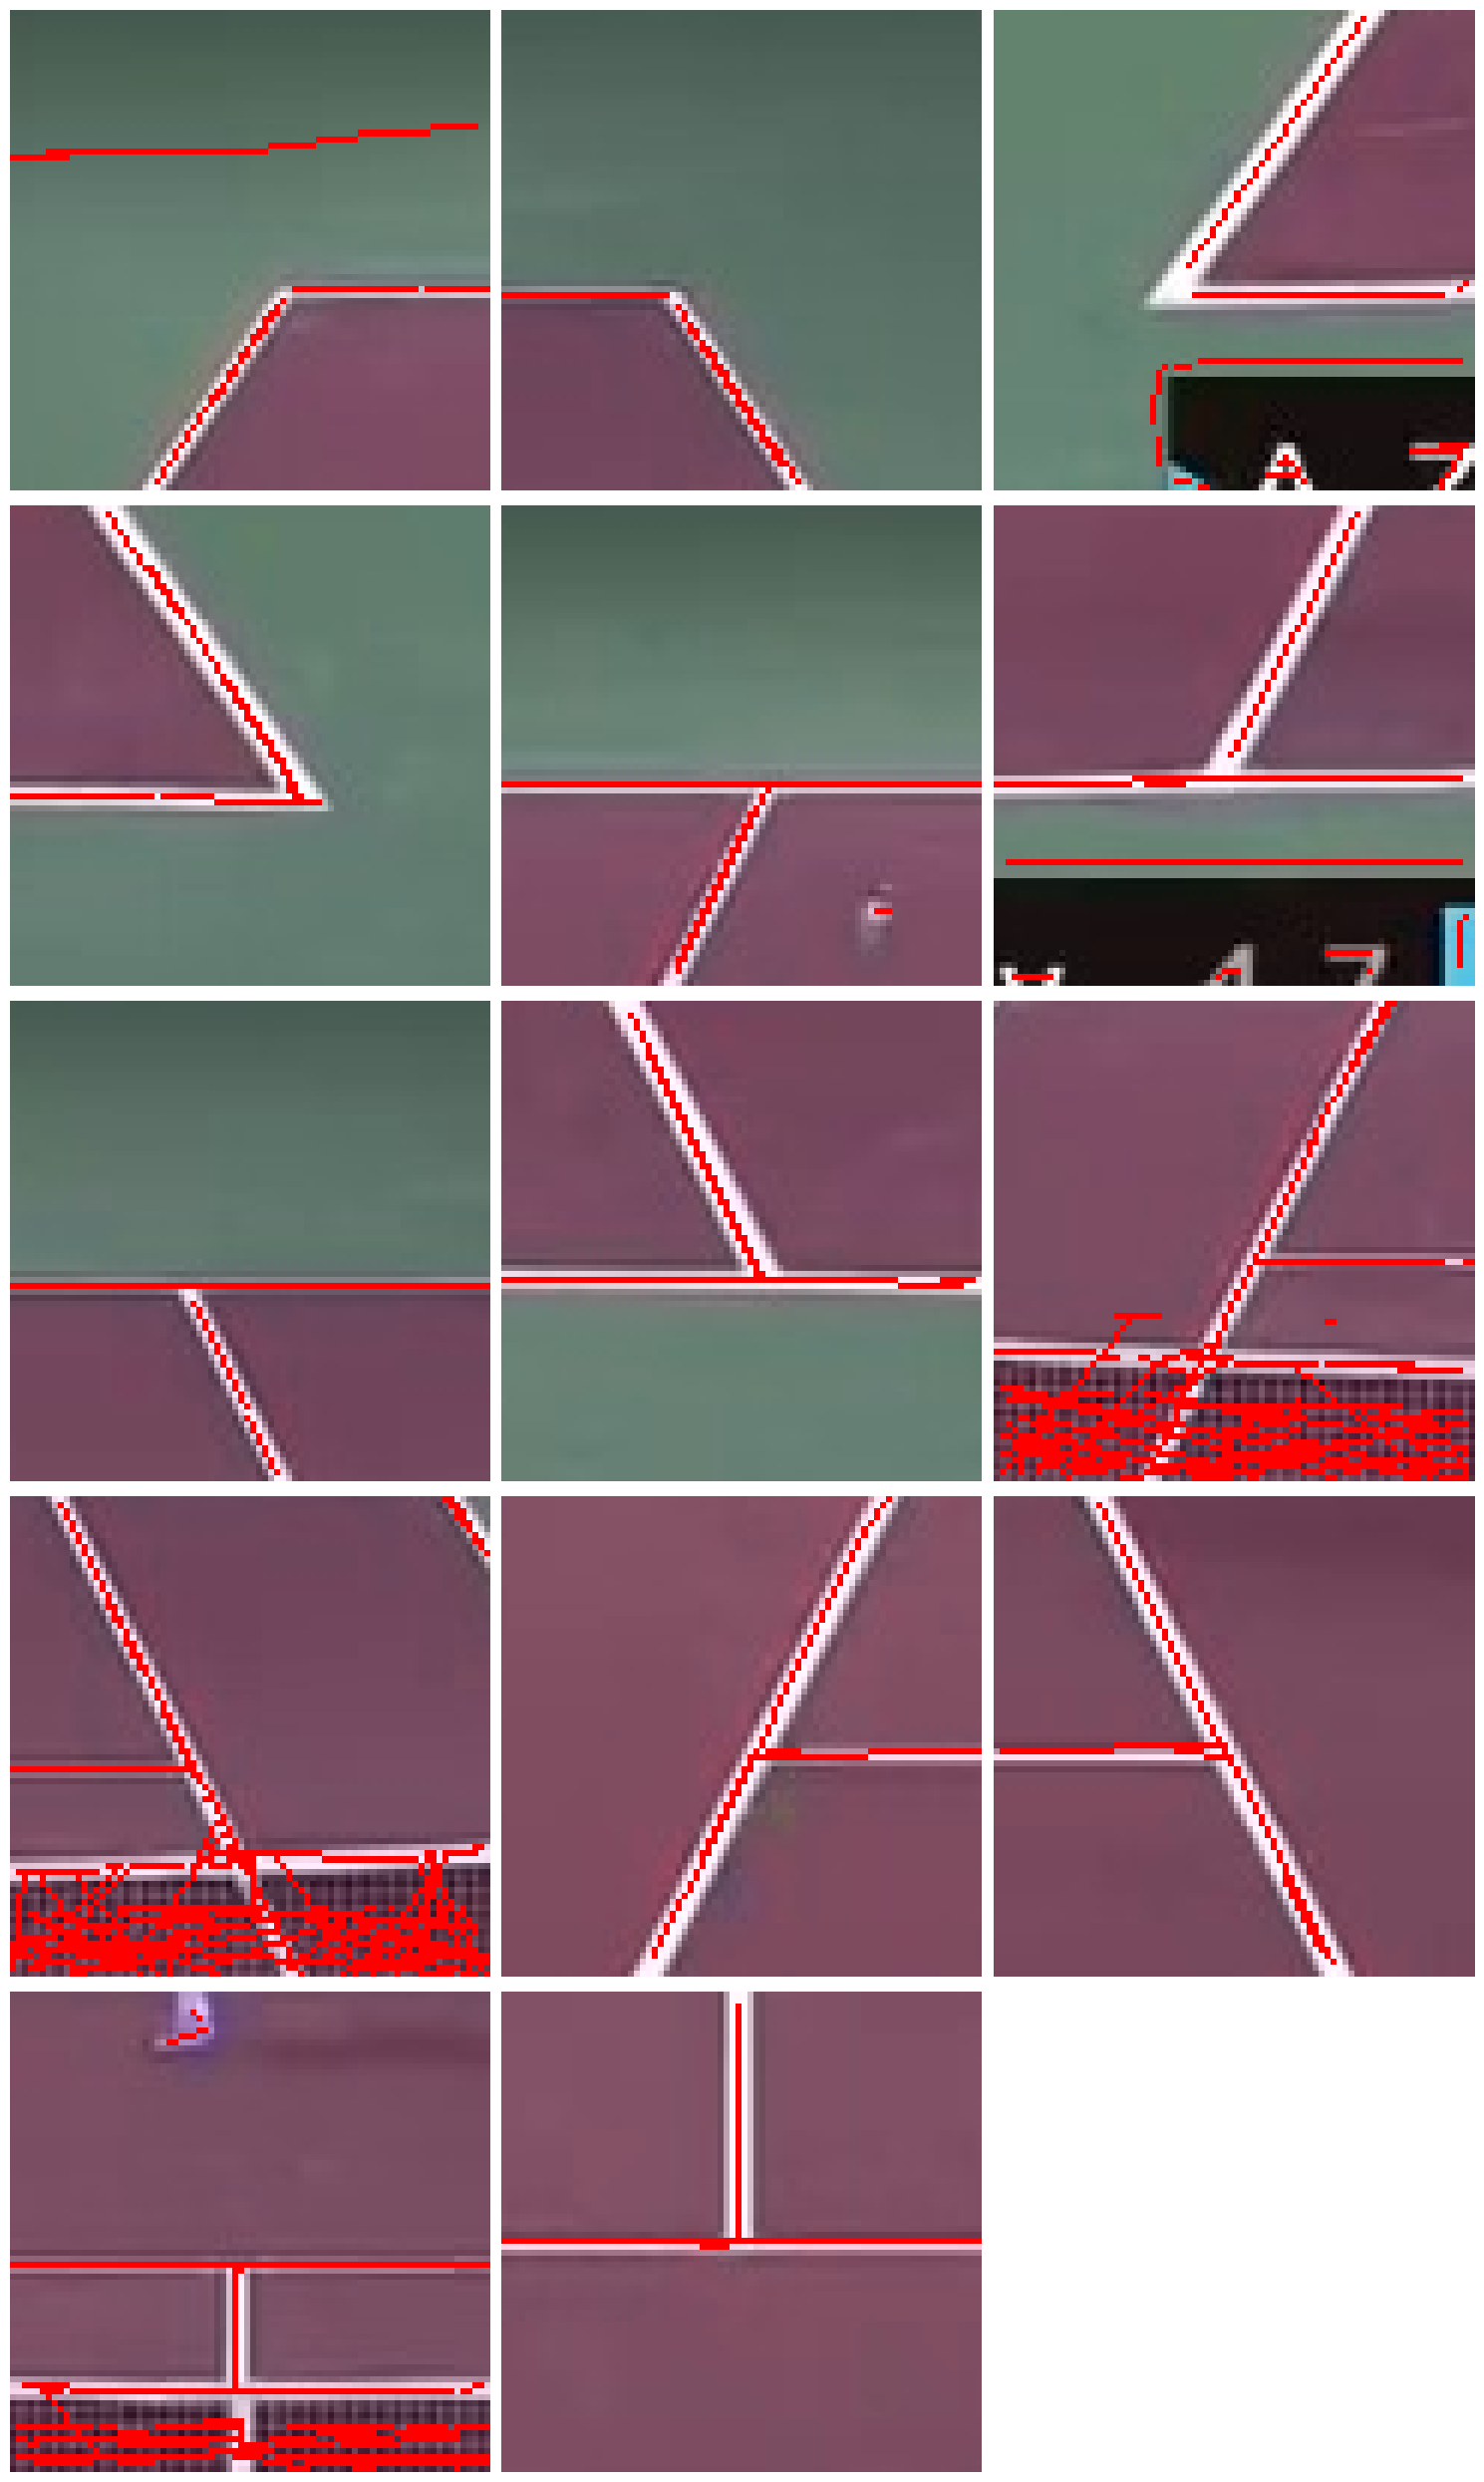

In [12]:
n_keypoints = len(keypoints)
n_cols = 3
n_rows = (n_keypoints + n_cols - 1) // n_cols

lines = []
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
for i, skeleton in enumerate(skeletons):

    # Hough Transform - Line Detection
    houghLinesP = cv2.HoughLinesP(skeleton, 1, np.pi / 180, 4, minLineLength=0, maxLineGap=9)

    # Showing the detected hough lines
    crop_copy = cropped_images[i].copy()
    if houghLinesP is not None:
        houghLinesP = np.squeeze(houghLinesP)
        for line in houghLinesP:
            x1, y1, x2, y2 = line
            cv2.line(crop_copy, (x1, y1), (x2, y2), (255, 0, 0), 1)
        lines.append(houghLinesP)

    row, col = divmod(i, n_cols)
    axs[row, col].imshow(crop_copy, cmap='gray')
    axs[row, col].axis('off')

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

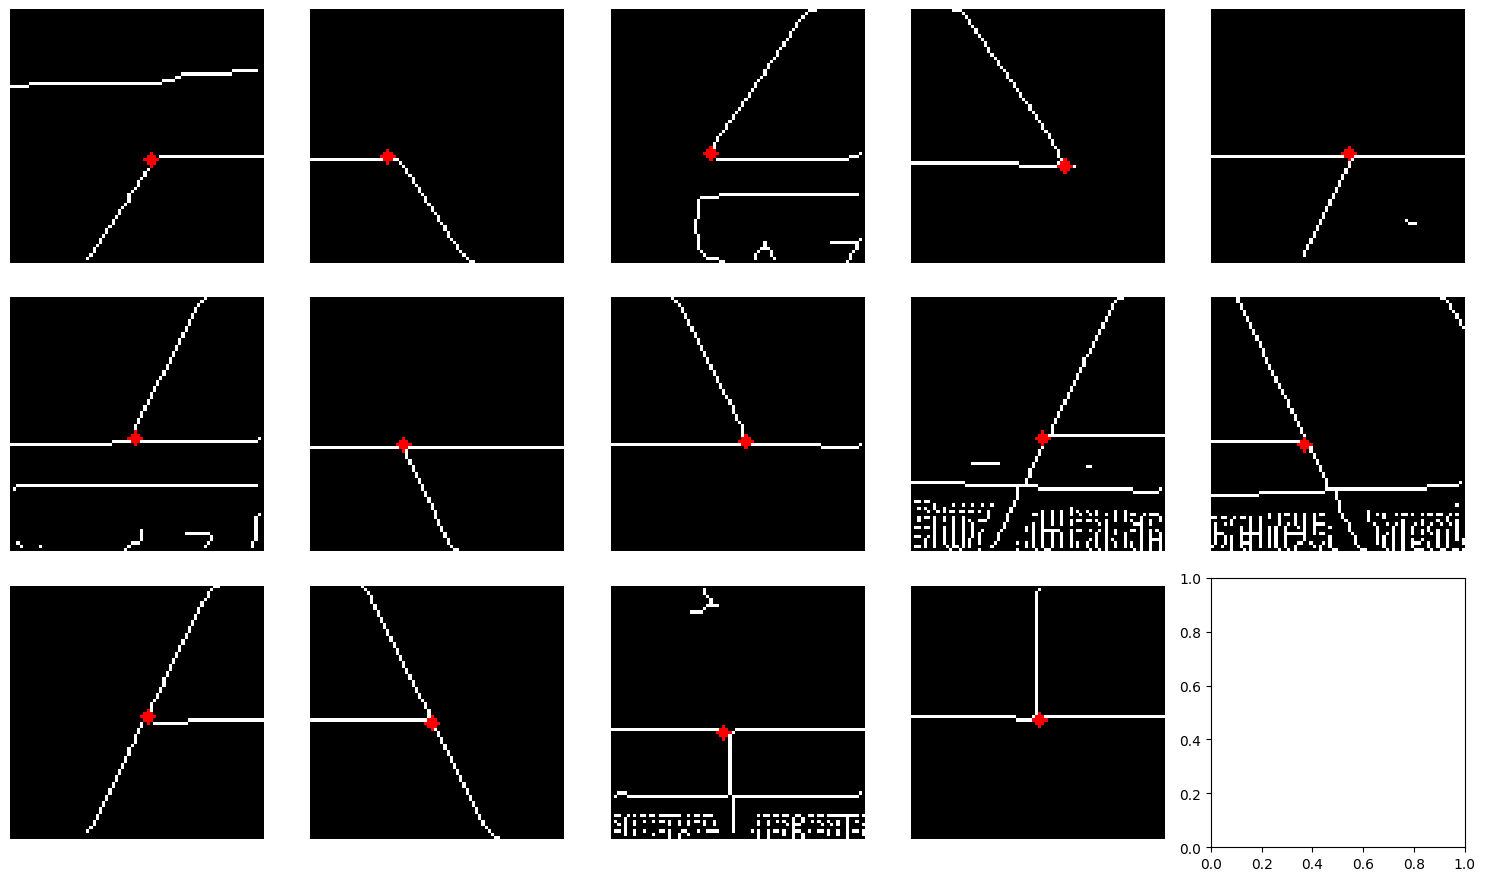

In [13]:
def detect_and_draw_intersections(image):
    # Detectar bordes en la imagen
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Detectar líneas en la imagen usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=0, maxLineGap=9)

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    intersections = []

    if lines is not None:
        for line1 in lines:
            for line2 in lines:
                if np.array_equal(line1, line2):
                    continue
                x1, y1, x2, y2 = line1[0]
                x3, y3, x4, y4 = line2[0]

                denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if denom != 0:
                    Px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
                    Py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
                    if 0 <= Px < image.shape[1] and 0 <= Py < image.shape[0]:
                        intersections.append((int(Px), int(Py)))

    # Eliminar intersecciones duplicadas o cercanas
    filtered_intersections = []
    for point in intersections:
        if not any(np.linalg.norm(np.array(point) - np.array(p)) < 10 for p in filtered_intersections):
            filtered_intersections.append(point)

    # Encontrar la intersección más cercana al centro
    center = (image.shape[1] // 2, image.shape[0] // 2)
    if filtered_intersections:
        closest_point = min(filtered_intersections, key=lambda point: np.linalg.norm(np.array(point) - np.array(center)))
    else:
        closest_point = center  # Si no se encuentra ninguna intersección, usar el centro

    # Dibujar un círculo rojo en la intersección más cercana al centro (o en el centro)
    cv2.circle(output_image, closest_point, 2, (0, 0, 255), -1)

    return output_image, closest_point

intersections_coordinates = []
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()

for i, sk in enumerate(skeletons):
    result_image, closest_point = detect_and_draw_intersections(sk)
    intersections_coordinates.append((i, closest_point))
    axs[i].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

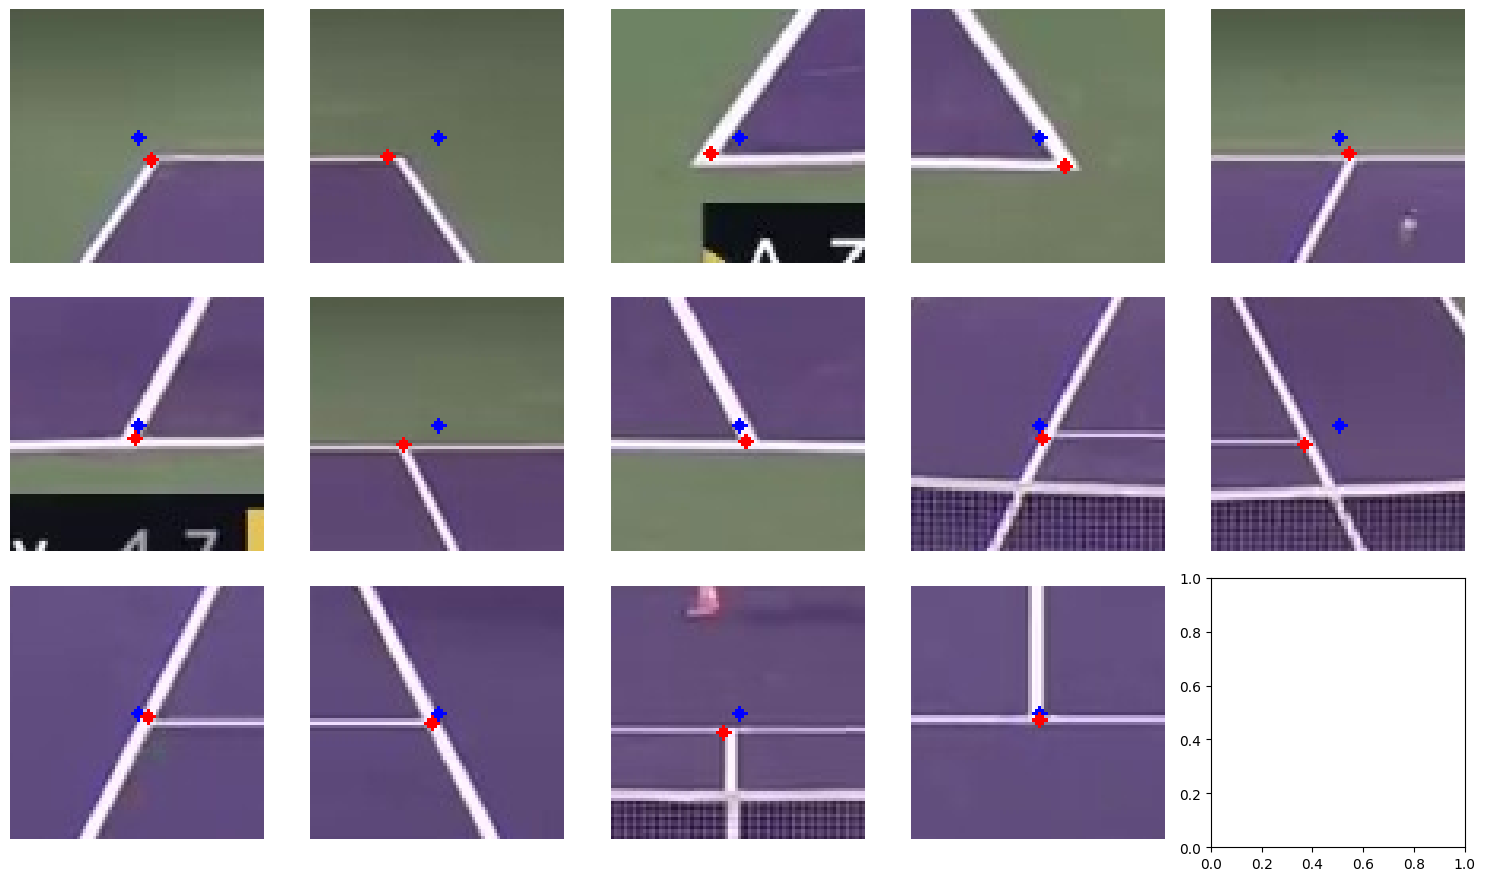

Diferencias en píxeles (dx, dy) desde el centro (punto azul) al punto rojo:
Imagen 0: dx = 4, dy = 7
Imagen 1: dx = -16, dy = 6
Imagen 2: dx = -9, dy = 5
Imagen 3: dx = 8, dy = 9
Imagen 4: dx = 3, dy = 5
Imagen 5: dx = -1, dy = 4
Imagen 6: dx = -11, dy = 6
Imagen 7: dx = 2, dy = 5
Imagen 8: dx = 1, dy = 4
Imagen 9: dx = -11, dy = 6
Imagen 10: dx = 3, dy = 1
Imagen 11: dx = -2, dy = 3
Imagen 12: dx = -5, dy = 6
Imagen 13: dx = 0, dy = 2


In [14]:
# Lista para guardar las distancias (diferencias en píxeles)
distances = []

def draw_circle_on_image(image, coord):
    if len(image.shape) == 2 or image.shape[2] == 1:  # La imagen está en escala de grises
        output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output_image = image.copy()  # La imagen ya está en color

    # Dibujar un círculo azul en el centro
    center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.circle(output_image, center, 2, (255, 0, 0), -1)

    # Dibujar un círculo rojo en la coordenada guardada
    if coord:
        cv2.circle(output_image, coord, 2, (0, 0, 255), -1)
        # Calcular la diferencia en x y y entre el centro y la coordenada guardada
        delta_x = coord[0] - center[0]
        delta_y = coord[1] - center[1]
        distances.append((delta_x, delta_y))

    return output_image

# Crear un plot de 3x5 para las imágenes con círculos dibujados
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()

for i, (index, coord) in enumerate(intersections_coordinates):
    if i < len(cropped_images):
        result_image = draw_circle_on_image(cropped_images[i], coord)
        axs[i].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')

plt.tight_layout()
plt.show()

# Mostrar las diferencias guardadas
print("Diferencias en píxeles (dx, dy) desde el centro (punto azul) al punto rojo:")
for i, (dx, dy) in enumerate(distances):
    print(f"Imagen {i}: dx = {dx}, dy = {dy}")

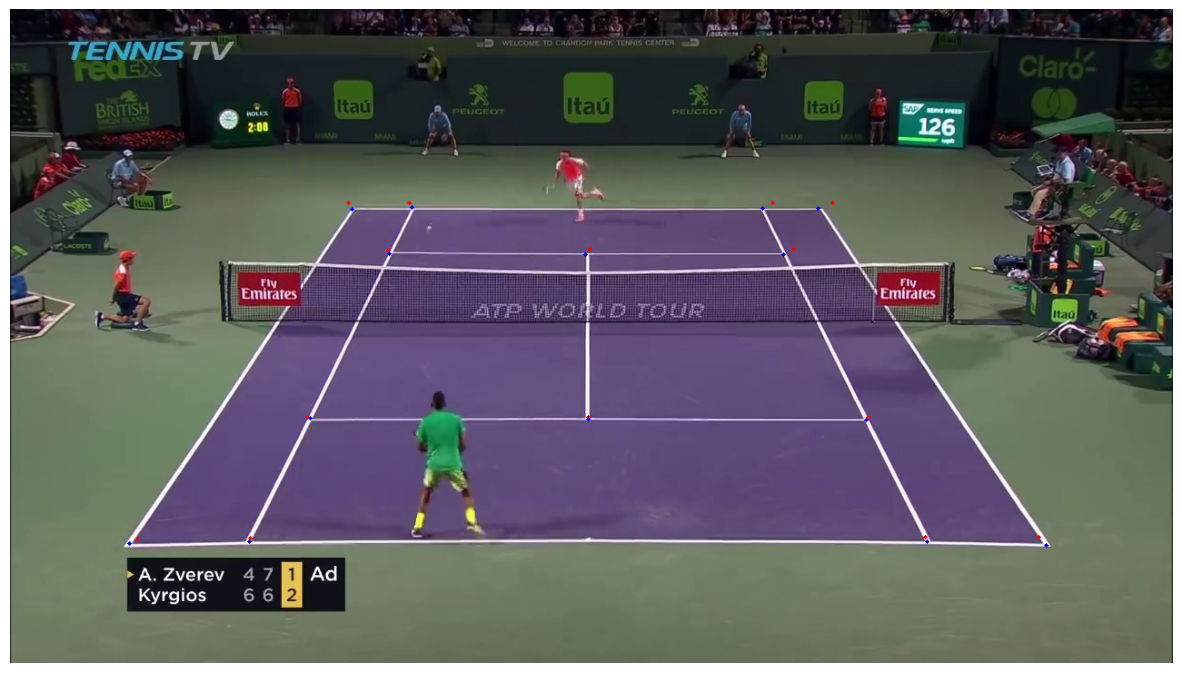

In [19]:
frame_kps = frame.copy()

for i, kp in enumerate(keypoints):
    x, y = kp
    cv2.circle(frame_kps, (int(x), int(y)), 2, (0, 0, 255), -1)
    cv2.circle(frame_kps, (int(x) + int(distances[i][0]), int(y) + int(distances[i][1])), 2, (255, 0, 0), -1)
    

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(frame_kps, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()